In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

input_iso = "IND"
# Read the yearly_full_release_long_format file
df_ember = pd.read_csv("../data/ember/yearly_full_release_long_format.csv")

# First, identify the Ember region for the input ISO
iso_region = df_ember[df_ember['Country code'] == input_iso]['Ember region'].iloc[0]
print(f"ISO {input_iso} belongs to Ember region: {iso_region}")

def get_metrics_by_year(df, filter_condition, level_name):
    """Extract generation, emissions, and capacity data by year for given filter condition"""
    
    # Filter data based on condition
    df_filtered = df[filter_condition].copy()
    
    # Define fossil fuel types
    fossil_fuels = ['Coal', 'Gas', 'Other Fossil']
    
    # Get fossil generation data by year (only TWh units)
    fossil_generation_data = df_filtered[
        (df_filtered['Subcategory'] == "Fuel") & 
        (df_filtered['Variable'].isin(fossil_fuels)) &
        (df_filtered['Unit'] == "TWh")  # Only generation in TWh
    ].groupby('Year')['Value'].sum().reset_index()
    fossil_generation_data.columns = ['Year', 'Fossil_Generation']
    
    # Get total generation data by year (for CO2 intensity)
    total_generation_data = df_filtered[
        df_filtered['Variable'] == "Total Generation"
    ].groupby('Year')['Value'].sum().reset_index()
    total_generation_data.columns = ['Year', 'Total_Generation']
    
    # Get emissions data by year
    emissions_data = df_filtered[
        df_filtered['Variable'] == "Total emissions"
    ].groupby('Year')['Value'].sum().reset_index()
    emissions_data.columns = ['Year', 'Emissions']
    
    # Get fossil capacity data by year
    fossil_capacity_data = df_filtered[
        (df_filtered['Subcategory'] == "Fuel") & 
        (df_filtered['Variable'].isin(fossil_fuels)) &
        (df_filtered['Unit'] == "GW")
    ].groupby('Year')['Value'].sum().reset_index()
    fossil_capacity_data.columns = ['Year', 'Fossil_Capacity']
    
    # Merge all data
    metrics_df = fossil_generation_data.merge(total_generation_data, on='Year', how='outer')
    metrics_df = metrics_df.merge(emissions_data, on='Year', how='outer')
    metrics_df = metrics_df.merge(fossil_capacity_data, on='Year', how='outer')
    
    # Calculate metrics
    metrics_df['Utilization_Factor'] = metrics_df['Fossil_Generation'] / metrics_df['Fossil_Capacity'] / 8.76
    metrics_df['CO2_Intensity'] = metrics_df['Emissions'] / metrics_df['Total_Generation']
    
    # Add level identifier
    metrics_df['Level'] = level_name
    
    return metrics_df

# Get metrics for all three levels
print("Processing ISO level...")
iso_metrics = get_metrics_by_year(
    df_ember, 
    df_ember['Country code'] == input_iso,
    f"ISO ({input_iso})"
)

print("Processing Ember region level...")
region_metrics = get_metrics_by_year(
    df_ember,
    df_ember['Ember region'] == iso_region,
    f"Region ({iso_region})"
)

print("Processing World level...")
world_metrics = get_metrics_by_year(
    df_ember,
    (df_ember['Country code'].notna()) & (df_ember['Country code'] != '') & (df_ember['Area type'] == 'Country'),
    "World"
)

# Combine all metrics
all_metrics = pd.concat([iso_metrics, region_metrics, world_metrics], ignore_index=True)

# Debug: Check what units we're actually getting and World filtering
print("\n=== DEBUG: CHECKING UNITS AND WORLD FILTERING ===")
fossil_fuels = ['Coal', 'Gas', 'Other Fossil']

# Check generation units
gen_units = df_ember[
    (df_ember['Country code'] == input_iso) & 
    (df_ember['Subcategory'] == "Fuel") & 
    (df_ember['Variable'].isin(fossil_fuels)) &
    (df_ember['Unit'] != "GW")
]['Unit'].unique()
print(f"Fossil generation units for {input_iso}: {gen_units}")

# Check capacity units  
cap_units = df_ember[
    (df_ember['Country code'] == input_iso) & 
    (df_ember['Subcategory'] == "Fuel") & 
    (df_ember['Variable'].isin(fossil_fuels)) &
    (df_ember['Unit'] == "GW")
]['Unit'].unique()
print(f"Fossil capacity units for {input_iso}: {cap_units}")

# Check World filtering - are we including blank/empty country codes?
world_countries = df_ember[
    df_ember['Country code'].notna() & (df_ember['Country code'] != '')
]['Country code'].nunique()
print(f"Number of countries in World calculation: {world_countries}")

# Check if there are any problematic entries
world_filter = df_ember['Country code'].notna() & (df_ember['Country code'] != '')
print(f"Total World records: {world_filter.sum()}")

# Check for any area types that might be causing issues
area_types = df_ember[world_filter]['Area type'].unique()
print(f"Area types in World data: {area_types}")

# Check if we're accidentally including regional aggregates
sample_areas = df_ember[world_filter]['Area'].value_counts().head(10)
print(f"Top 10 areas in World data:")
print(sample_areas)

print("Data processing complete!")
display(all_metrics.head(10))





ISO IND belongs to Ember region: Asia
Processing ISO level...
Processing Ember region level...
Processing World level...

=== DEBUG: CHECKING UNITS AND WORLD FILTERING ===
Fossil generation units for IND: ['%' 'TWh' 'mtCO2']
Fossil capacity units for IND: ['GW']
Number of countries in World calculation: 215
Total World records: 324348
Area types in World data: ['Country']
Top 10 areas in World data:
Area
Bolivia        1584
Bangladesh     1584
Austria        1584
Belgium        1584
Denmark        1584
Czechia        1584
Bulgaria       1584
Colombia       1584
El Salvador    1584
Finland        1584
Name: count, dtype: int64
Data processing complete!


,Year,Fossil_Generation,Total_Generation,Emissions,Fossil_Capacity,Utilization_Factor,CO2_Intensity,Level
0,2000,475.35,571.39,422.85,81.57,0.665241,0.740037,ISO (IND)
1,2001,491.01,586.09,438.04,83.65,0.670070,0.747394,ISO (IND)
2,2002,517.51,609.64,460.74,85.67,0.689582,0.755757,ISO (IND)
3,2003,545.36,638.13,483.70,88.01,0.707371,0.757996,ISO (IND)
4,2004,567.86,698.32,505.44,89.07,0.727789,0.723794,ISO (IND)
5,2005,579.32,704.52,517.14,93.71,0.705714,0.734032,ISO (IND)
6,2006,599.24,744.43,538.24,97.45,0.701964,0.723023,ISO (IND)
7,2007,636.68,796.26,571.61,105.39,0.689632,0.717869,ISO (IND)
8,2008,674.27,828.41,607.29,110.95,0.693749,0.733079,ISO (IND)
9,2009,728.56,879.71,654.41,119.56,0.695625,0.743893,ISO (IND)


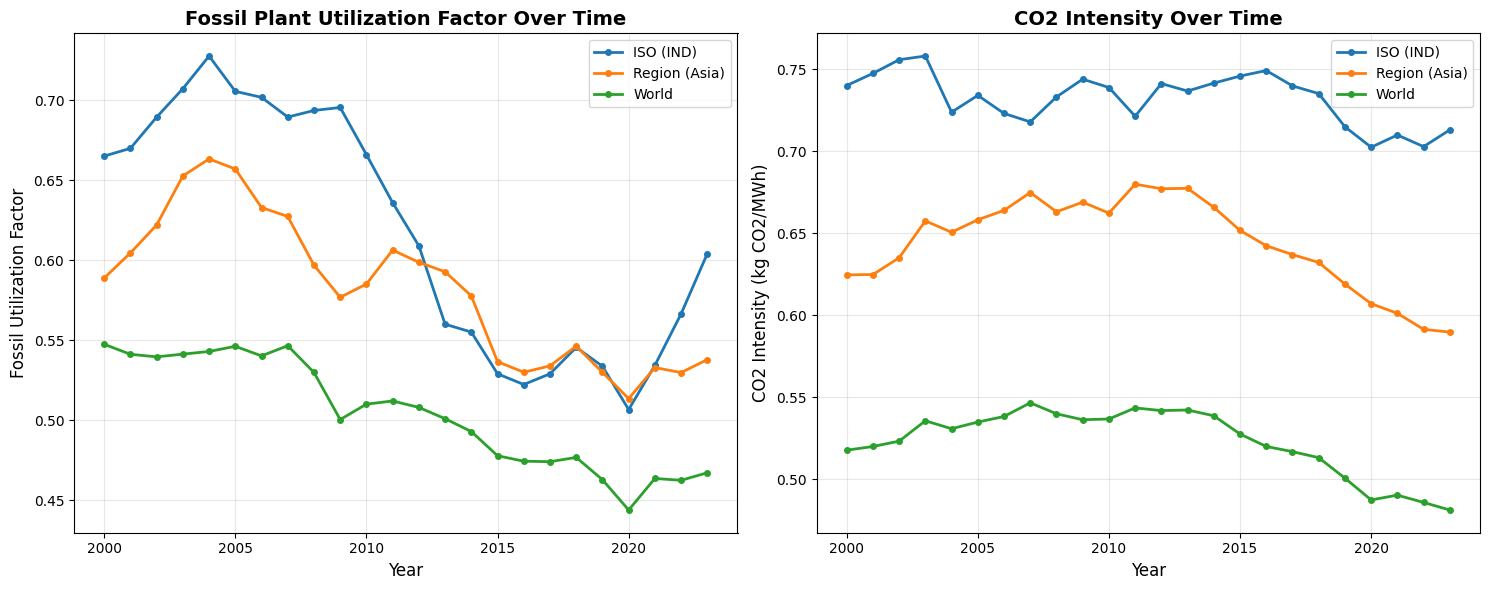


=== DEBUG: DATA INSPECTION ===

ISO (IND) - Sample Data:
  Year 2023:
    Fossil Generation: 1528.1
    Fossil Capacity: 288.7
    Utilization Factor: 0.604
    Raw calculation: 1528.1 / 288.7 / 8.76 = 0.604

Region (Asia) - Sample Data:
  Year 2023:
    Fossil Generation: 10204.5
    Fossil Capacity: 2165.1
    Utilization Factor: 0.538
    Raw calculation: 10204.5 / 2165.1 / 8.76 = 0.538

World - Sample Data:
  Year 2023:
    Fossil Generation: 17110.4
    Fossil Capacity: 4180.2
    Utilization Factor: 0.467
    Raw calculation: 17110.4 / 4180.2 / 8.76 = 0.467

=== SUMMARY STATISTICS ===

ISO (IND):
  Years available: 2000 - 2023
  Avg Fossil Utilization Factor: 0.619
  Max Fossil Utilization Factor: 0.728
  Avg CO2 Intensity: 0.7 kg CO2/MWh
  Latest Fossil Utilization Factor (2023): 0.604
  Latest CO2 Intensity (2023): 0.7 kg CO2/MWh

Region (Asia):
  Years available: 2000 - 2023
  Avg Fossil Utilization Factor: 0.582
  Max Fossil Utilization Factor: 0.663
  Avg CO2 Intensity: 0.6

In [2]:
# Create the two line charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Utilization Factor Over Time
for level in [f"ISO ({input_iso})", f"Region ({iso_region})", "World"]:
    level_data = all_metrics[all_metrics['Level'] == level].copy()
    level_data = level_data.dropna(subset=['Utilization_Factor'])
    level_data = level_data.sort_values('Year')
    
    ax1.plot(level_data['Year'], level_data['Utilization_Factor'], 
             marker='o', linewidth=2, label=level, markersize=4)

ax1.set_title('Fossil Plant Utilization Factor Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Fossil Utilization Factor', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: CO2 Intensity Over Time
for level in [f"ISO ({input_iso})", f"Region ({iso_region})", "World"]:
    level_data = all_metrics[all_metrics['Level'] == level].copy()
    level_data = level_data.dropna(subset=['CO2_Intensity'])
    level_data = level_data.sort_values('Year')
    
    ax2.plot(level_data['Year'], level_data['CO2_Intensity'], 
             marker='o', linewidth=2, label=level, markersize=4)

ax2.set_title('CO2 Intensity Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('CO2 Intensity (kg CO2/MWh)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Debug: Check data units and values
print("\n=== DEBUG: DATA INSPECTION ===")
for level in [f"ISO ({input_iso})", f"Region ({iso_region})", "World"]:
    level_data = all_metrics[all_metrics['Level'] == level].copy()
    level_data = level_data.dropna(subset=['Utilization_Factor'])
    
    if len(level_data) > 0:
        print(f"\n{level} - Sample Data:")
        sample_year = level_data['Year'].max()
        sample_data = level_data[level_data['Year'] == sample_year].iloc[0]
        
        print(f"  Year {sample_year}:")
        print(f"    Fossil Generation: {sample_data['Fossil_Generation']:.1f}")
        print(f"    Fossil Capacity: {sample_data['Fossil_Capacity']:.1f}")
        print(f"    Utilization Factor: {sample_data['Utilization_Factor']:.3f}")
        print(f"    Raw calculation: {sample_data['Fossil_Generation']:.1f} / {sample_data['Fossil_Capacity']:.1f} / 8.76 = {sample_data['Fossil_Generation'] / sample_data['Fossil_Capacity'] / 8.76:.3f}")

# Display summary statistics
print("\n=== SUMMARY STATISTICS ===")
for level in [f"ISO ({input_iso})", f"Region ({iso_region})", "World"]:
    level_data = all_metrics[all_metrics['Level'] == level].copy()
    level_data = level_data.dropna(subset=['Utilization_Factor', 'CO2_Intensity'])
    
    if len(level_data) > 0:
        print(f"\n{level}:")
        print(f"  Years available: {level_data['Year'].min():.0f} - {level_data['Year'].max():.0f}")
        print(f"  Avg Fossil Utilization Factor: {level_data['Utilization_Factor'].mean():.3f}")
        print(f"  Max Fossil Utilization Factor: {level_data['Utilization_Factor'].max():.3f}")
        print(f"  Avg CO2 Intensity: {level_data['CO2_Intensity'].mean():.1f} kg CO2/MWh")
        print(f"  Latest Fossil Utilization Factor ({level_data['Year'].max():.0f}): {level_data[level_data['Year'] == level_data['Year'].max()]['Utilization_Factor'].iloc[0]:.3f}")
        print(f"  Latest CO2 Intensity ({level_data['Year'].max():.0f}): {level_data[level_data['Year'] == level_data['Year'].max()]['CO2_Intensity'].iloc[0]:.1f} kg CO2/MWh")
